In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'TEP.PA'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-06-30,1245,0,1245,57,177,515,0,862,681,...,97,8,84,493,17,562,91,-77,57.25,2014-07-28
1,2014-12-31,1513,0,1513,95,216,693,0,1110,1019,...,123,2,201,767,424,1332,109,-83,57.25,2015-02-14
2,2015-06-30,1658,0,1658,84,261,699,0,1174,1120,...,119,0,240,819,450,1406,190,-88,57.97,2015-07-28
3,2015-12-31,1740,0,1740,119,257,754,0,1197,1123,...,117,0,151,745,468,1341,201,-86,57.97,2016-02-14
4,2016-06-30,1689,0,1689,87,255,734,0,1196,1097,...,115,5,172,797,416,1336,196,-76,58.31,2016-07-28


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
15,2021-12-31,2022-02-14,59.53,3684,0,3684,302,837,1580,0,...,1422,8346,280,2,716,2039,2270,5189,584,-132
16,2022-06-30,2022-07-28,59.71,3946,0,3946,274,756,1642,0,...,1466,8765,242,0,640,2010,2201,5164,616,-151
17,2022-12-31,2023-02-14,59.71,4208,0,4208,371,817,1707,0,...,1345,8864,232,4,884,2288,2021,5192,678,-147
18,2023-06-30,2023-07-28,59.10,3960,0,3960,271,727,1715,0,...,1256,8769,216,2,949,2271,1878,5049,590,-112
19,2023-12-31,2024-03-05,59.10,4385,0,4385,331,882,2132,0,...,1297,11754,334,15,1,2708,3822,7522,785,-121


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2021-12-31,2022-02-14,59.53,3684,0,3684,302,837,1580,0,...,8346,280,2,716,2039,2270,5189,584,-132,0.874514
16,2022-06-30,2022-07-28,59.71,3946,0,3946,274,756,1642,0,...,8765,242,0,640,2010,2201,5164,616,-151,0.938325
17,2022-12-31,2023-02-14,59.71,4208,0,4208,371,817,1707,0,...,8864,232,4,884,2288,2021,5192,678,-147,0.980663
18,2023-06-30,2023-07-28,59.10,3960,0,3960,271,727,1715,0,...,8769,216,2,949,2271,1878,5049,590,-112,0.918362
19,2023-12-31,2024-03-05,59.10,4385,0,4385,331,882,2132,0,...,11754,334,15,1,2708,3822,7522,785,-121,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2021-12-31,2022-02-14,59.53,3684,0,3684,302,837,1580,0,...,8346,280,2,716,2039,2270,5189,584,-132,0.874514
16,2022-06-30,2022-07-28,59.71,3946,0,3946,274,756,1642,0,...,8765,242,0,640,2010,2201,5164,616,-151,0.938325
17,2022-12-31,2023-02-14,59.71,4208,0,4208,371,817,1707,0,...,8864,232,4,884,2288,2021,5192,678,-147,0.980663
18,2023-06-30,2023-07-28,59.10,3960,0,3960,271,727,1715,0,...,8769,216,2,949,2271,1878,5049,590,-112,0.918362
19,2023-12-31,2024-03-05,59.10,4385,0,4385,331,882,2132,0,...,11754,334,15,1,2708,3822,7522,785,-121,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-07-28,42.048698,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.718437,0.281563,0.0,0.0,0.0,0.0,1.0,0.045783,0.0,0.0
1,2014-08-04,41.084507,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.718437,0.281563,0.0,0.0,0.0,0.0,1.0,0.045783,0.0,0.0
2,2014-08-11,41.030247,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.718437,0.281563,0.0,0.0,0.0,0.0,1.0,0.045783,0.0,0.0
3,2014-08-18,41.188869,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.718437,0.281563,0.0,0.0,0.0,0.0,1.0,0.045783,0.0,0.0
4,2014-08-25,41.230602,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.718437,0.281563,0.0,0.0,0.0,0.0,1.0,0.045783,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-07-28,42.048698,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.0,1.0,0.045783,0.0,0.0,inf,1.678722,inf,inf,inf
1,2014-08-04,41.084507,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.0,1.0,0.045783,0.0,0.0,inf,1.640229,inf,inf,inf
2,2014-08-11,41.030247,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.0,1.0,0.045783,0.0,0.0,inf,1.638063,inf,inf,inf
3,2014-08-18,41.188869,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.0,1.0,0.045783,0.0,0.0,inf,1.644395,inf,inf,inf
4,2014-08-25,41.230602,2014-06-30,1245.0,0.0,25.048035,57.25,0.0,0.0,177.0,...,0.0,1.0,0.045783,0.0,0.0,inf,1.646061,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

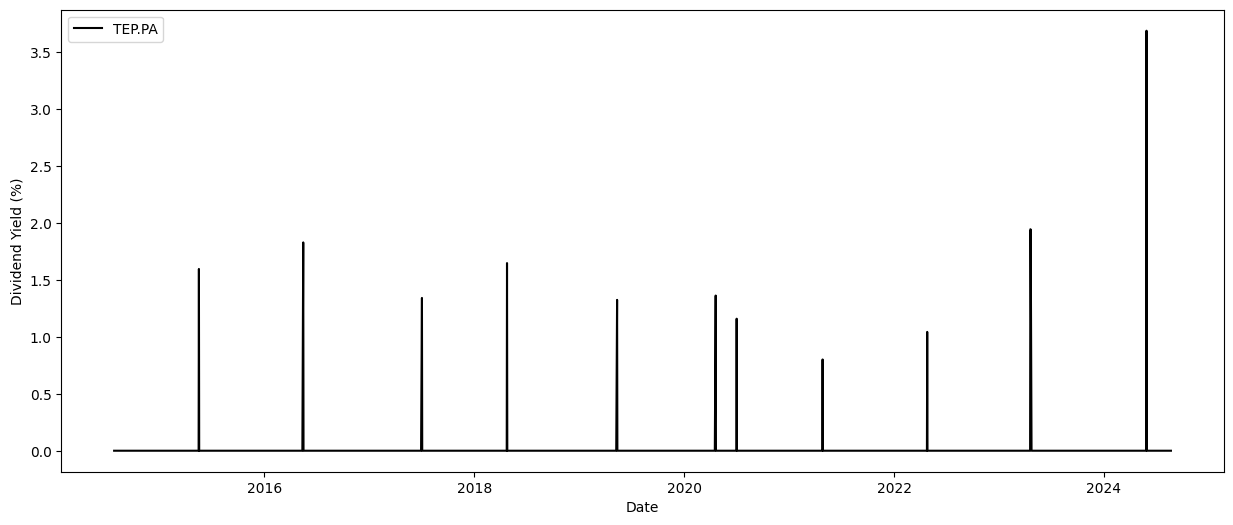

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.056855
share_price      1.000000
Name: share_price, dtype: float64


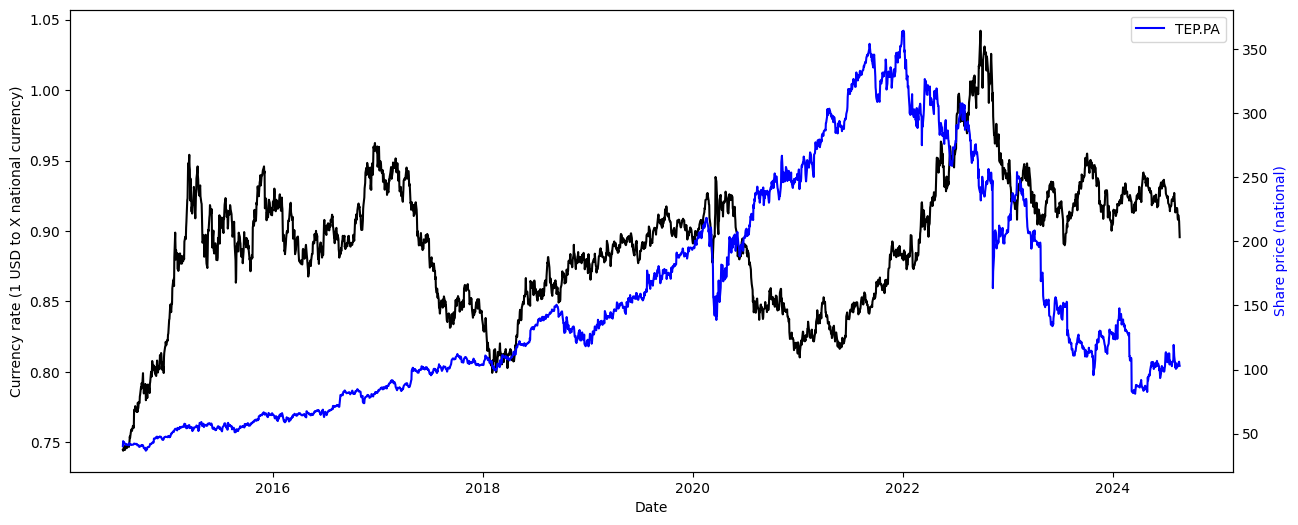

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

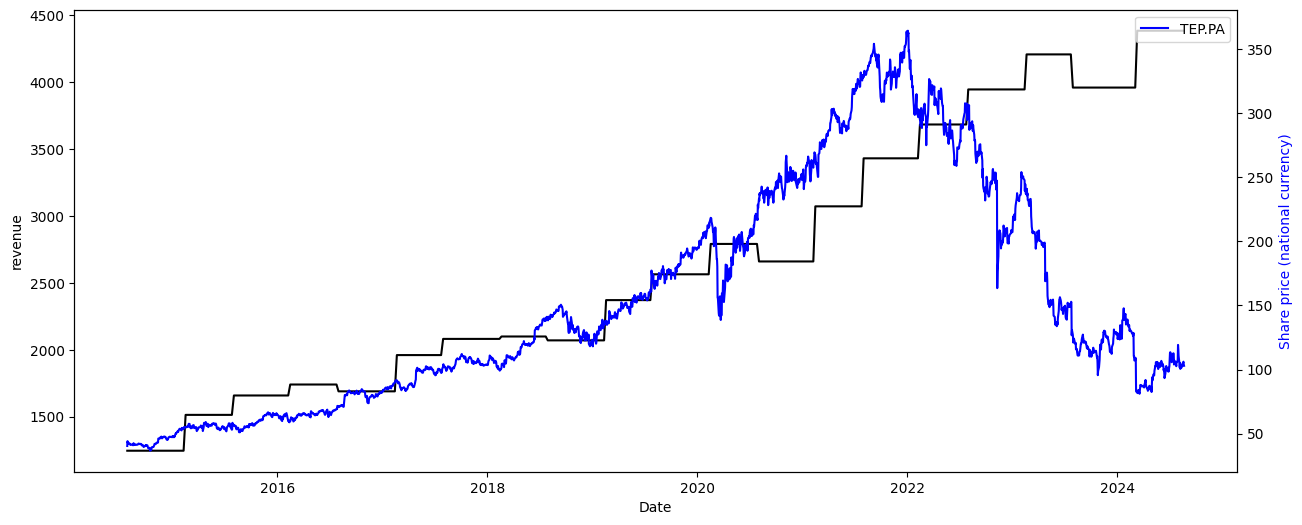

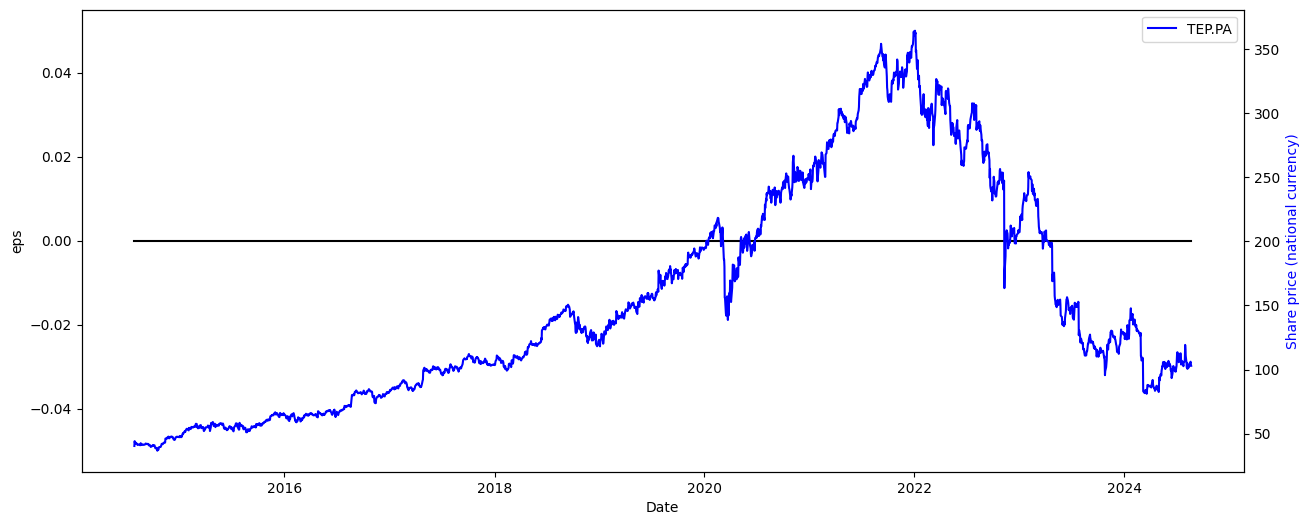

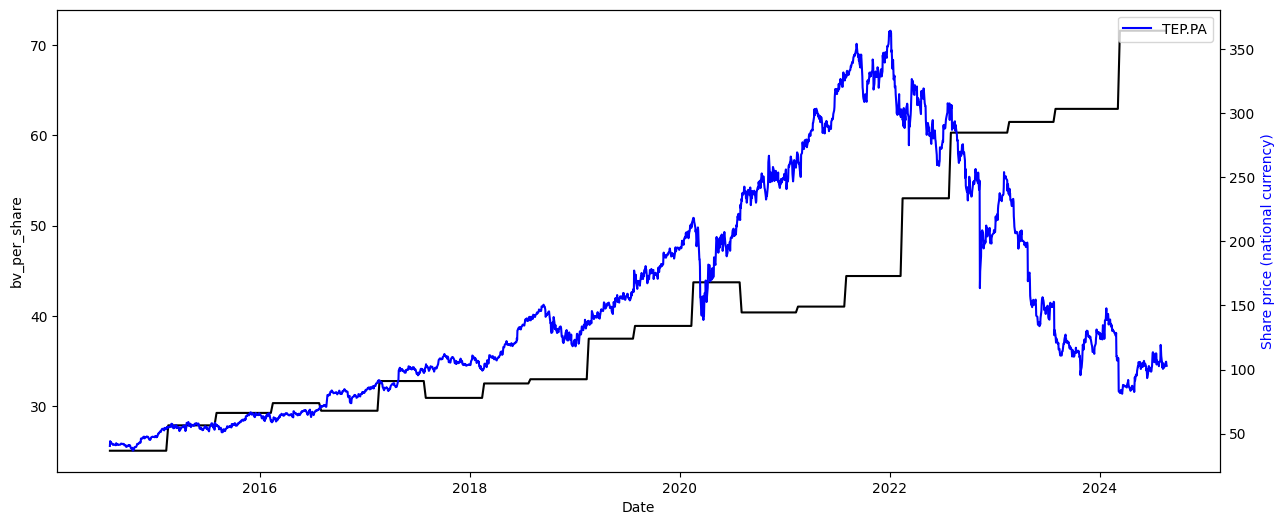

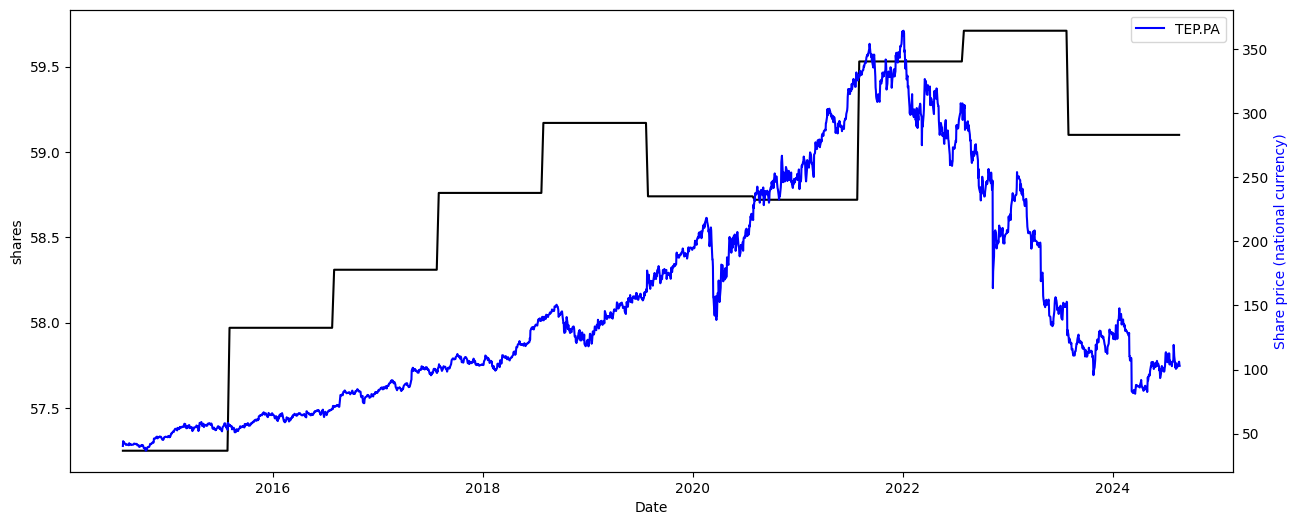

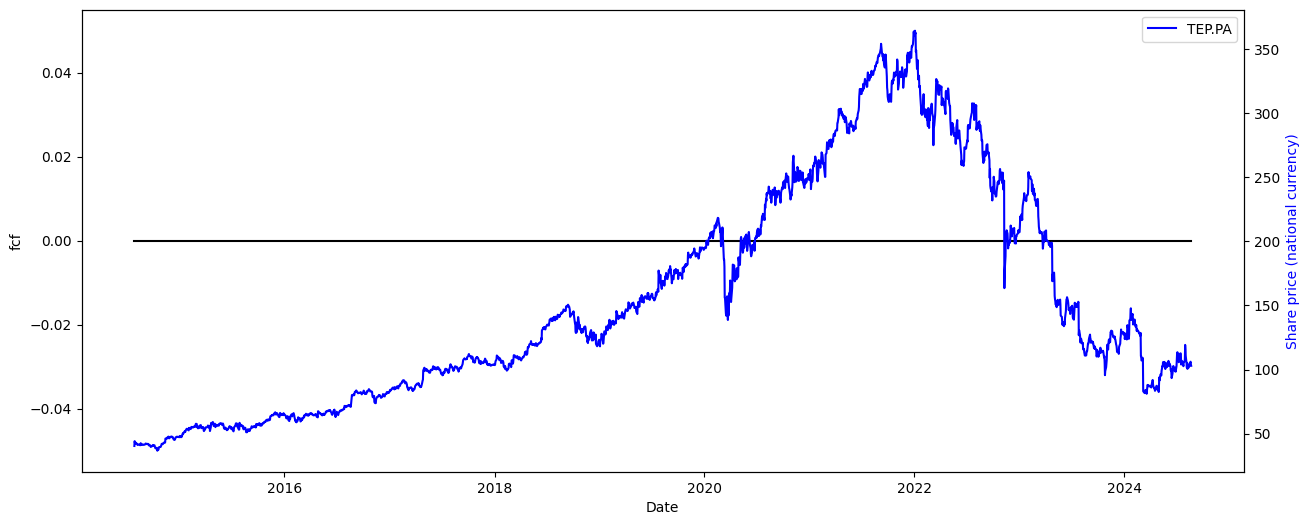

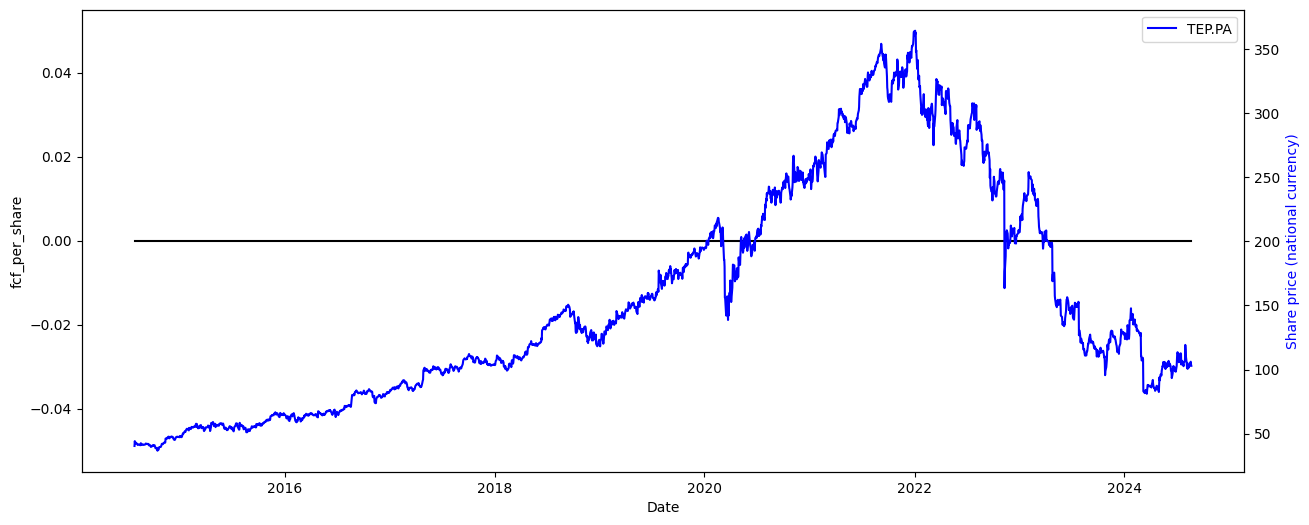

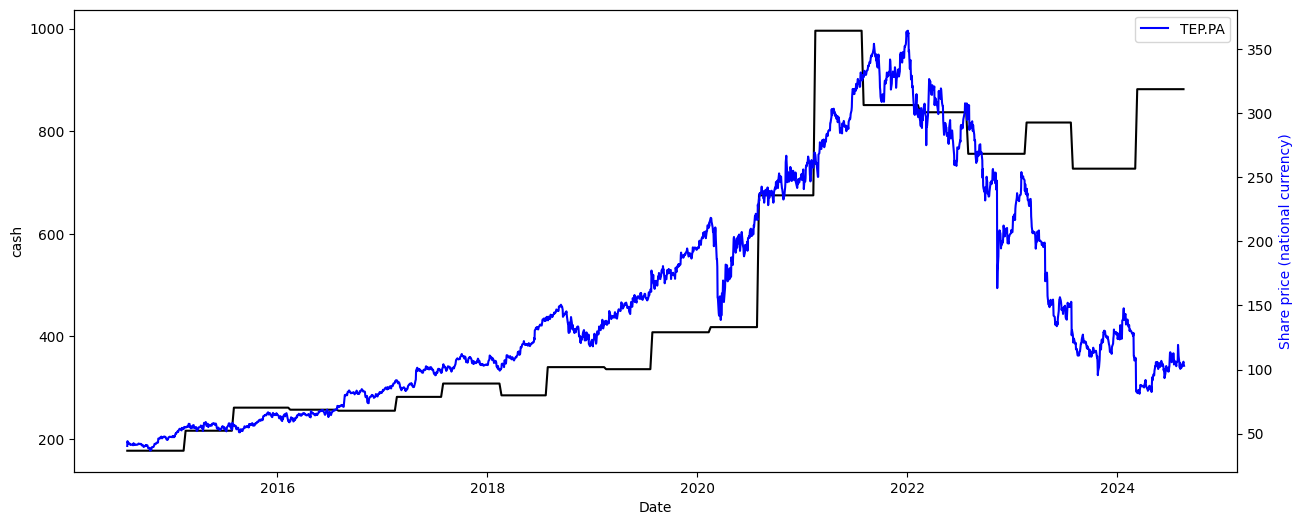

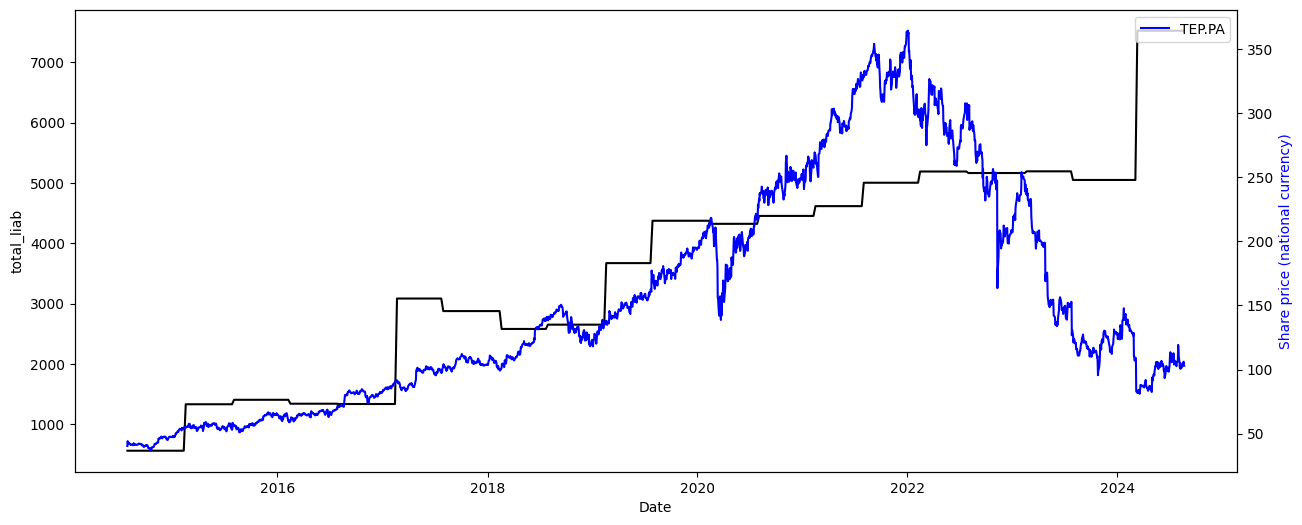

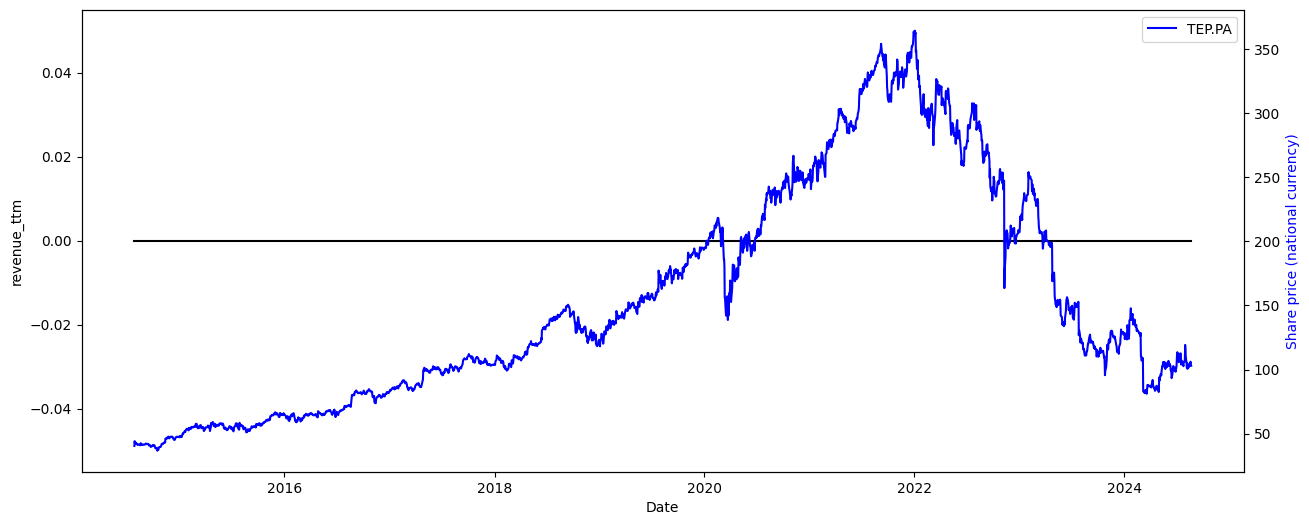

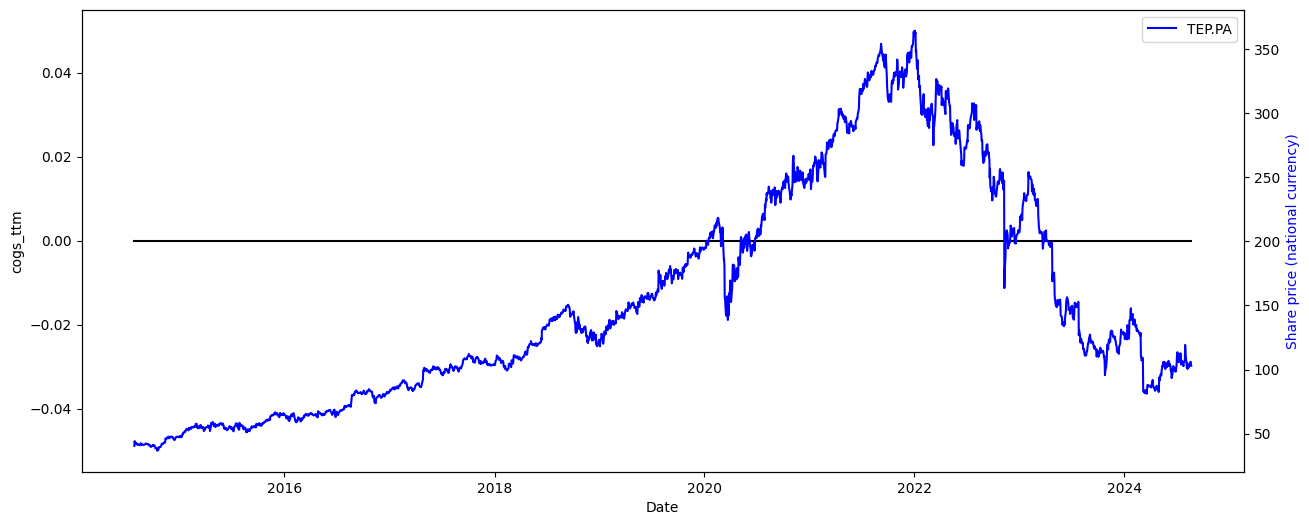

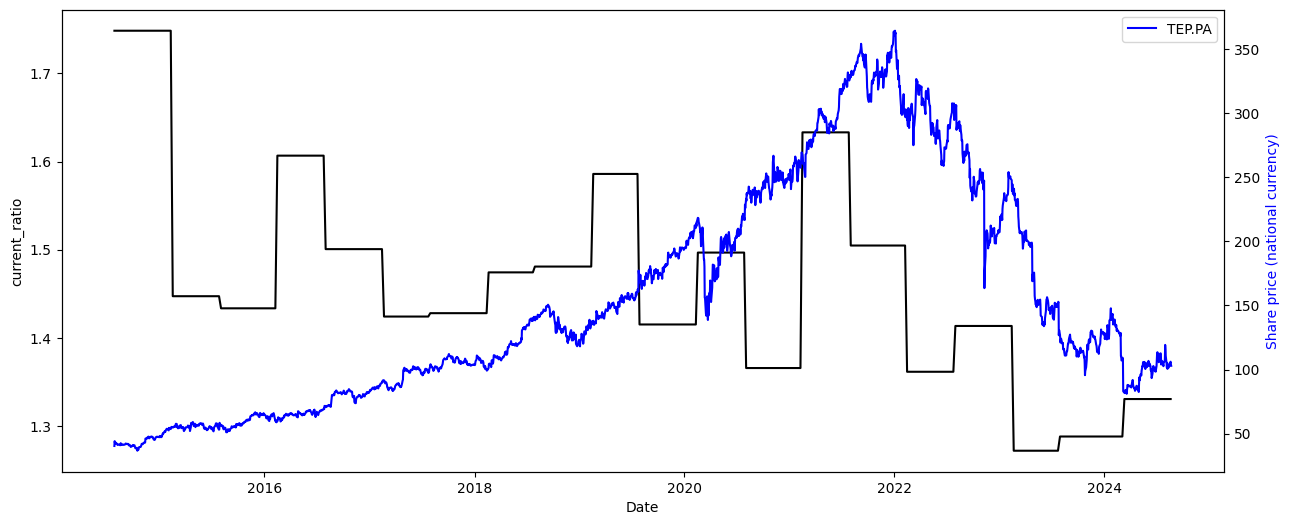

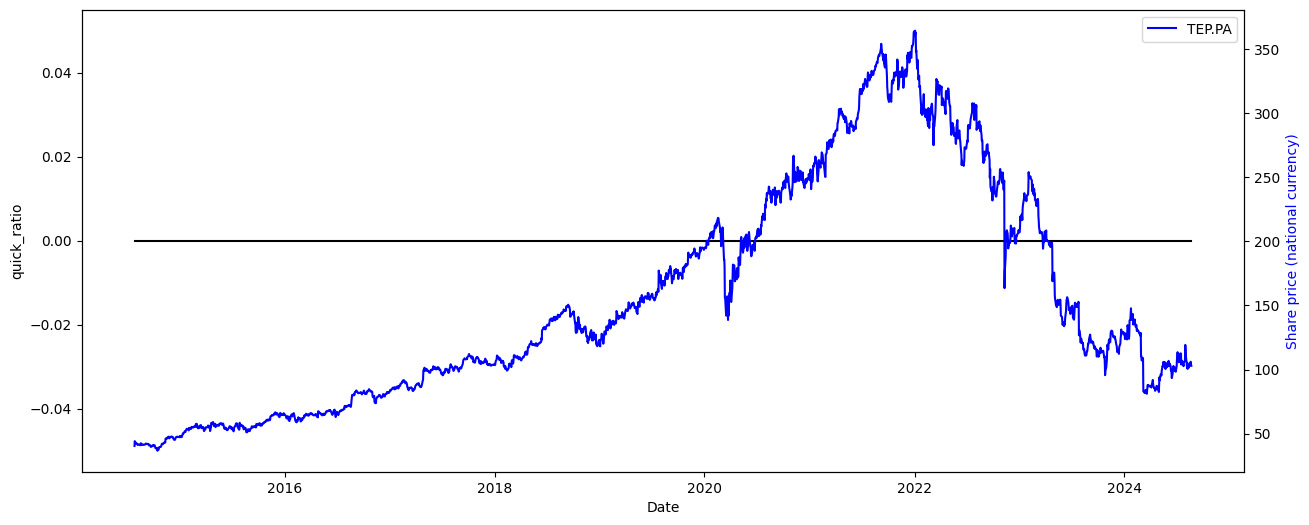

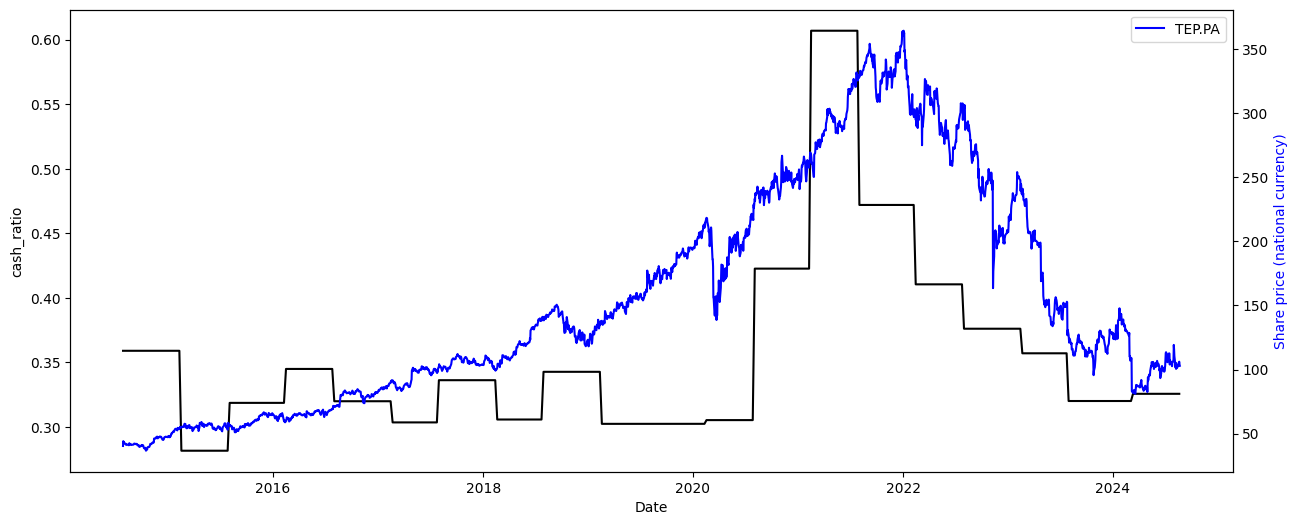

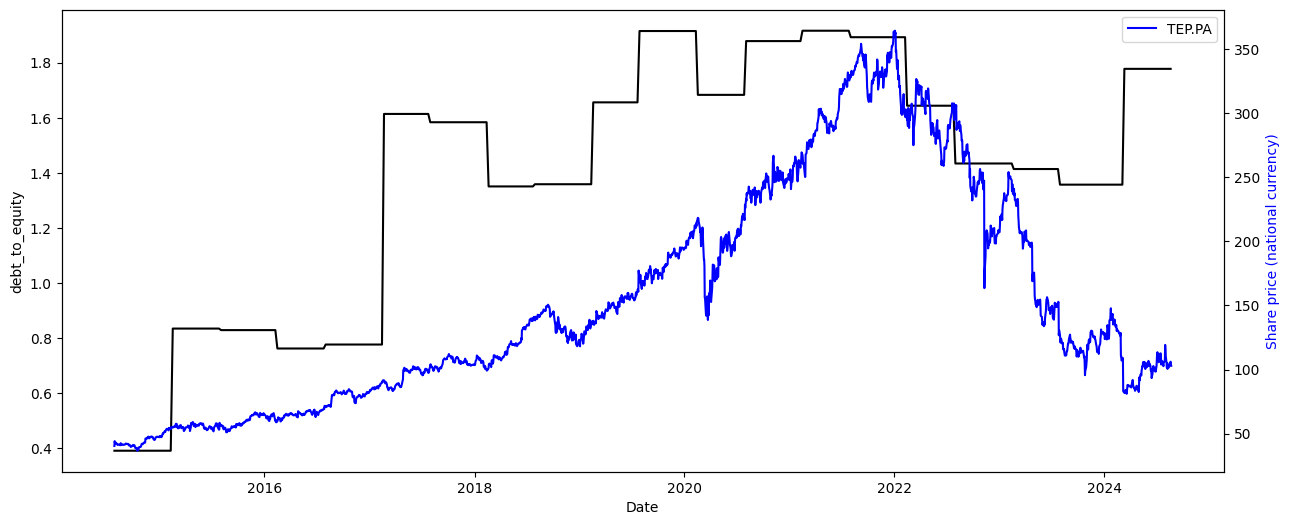

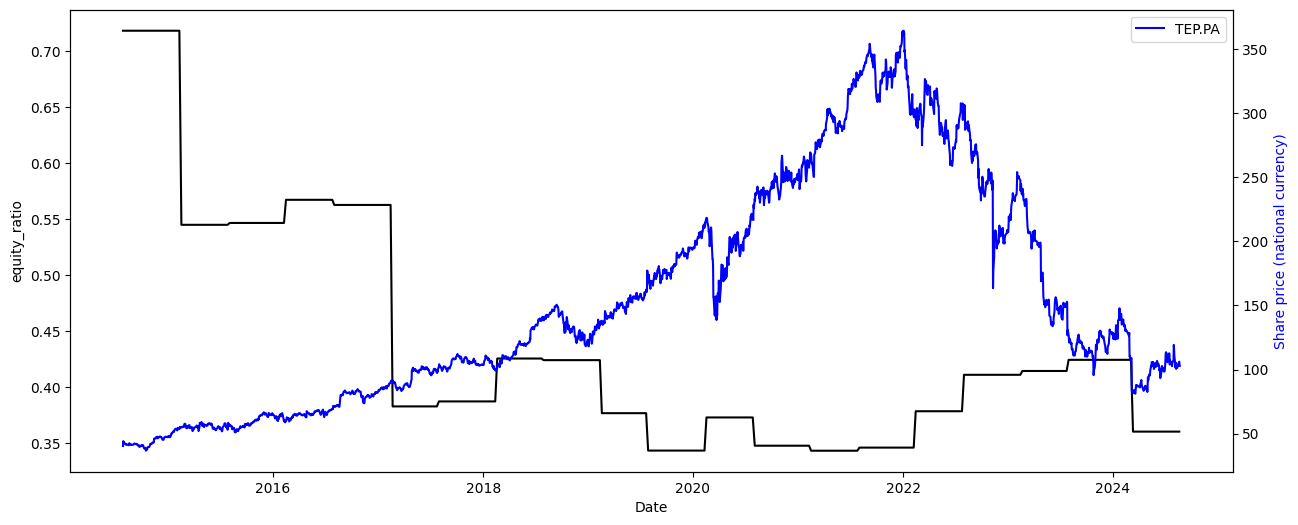

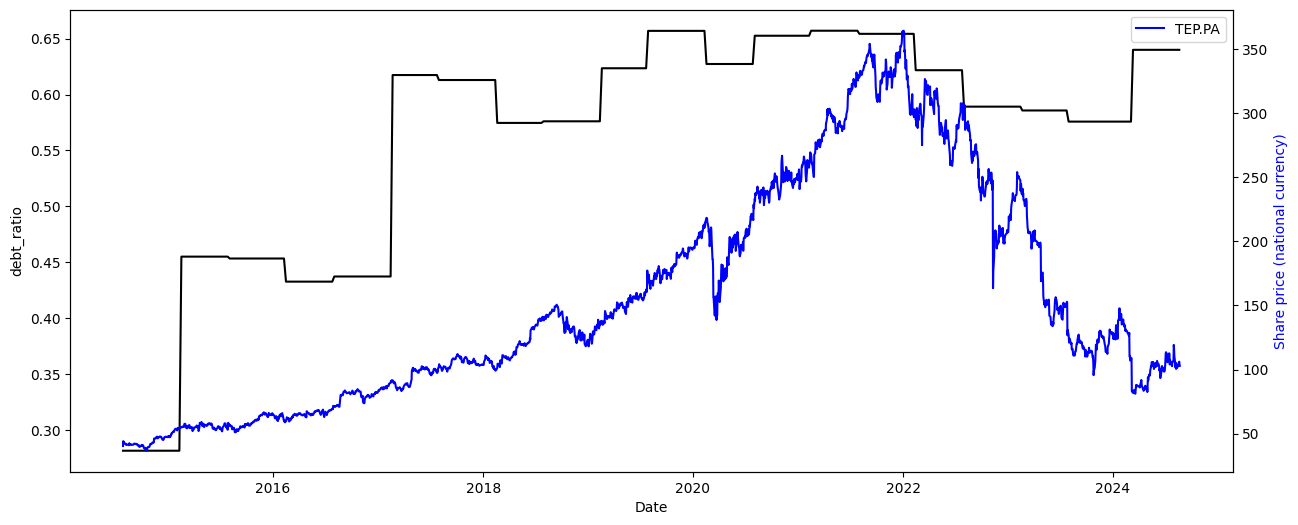

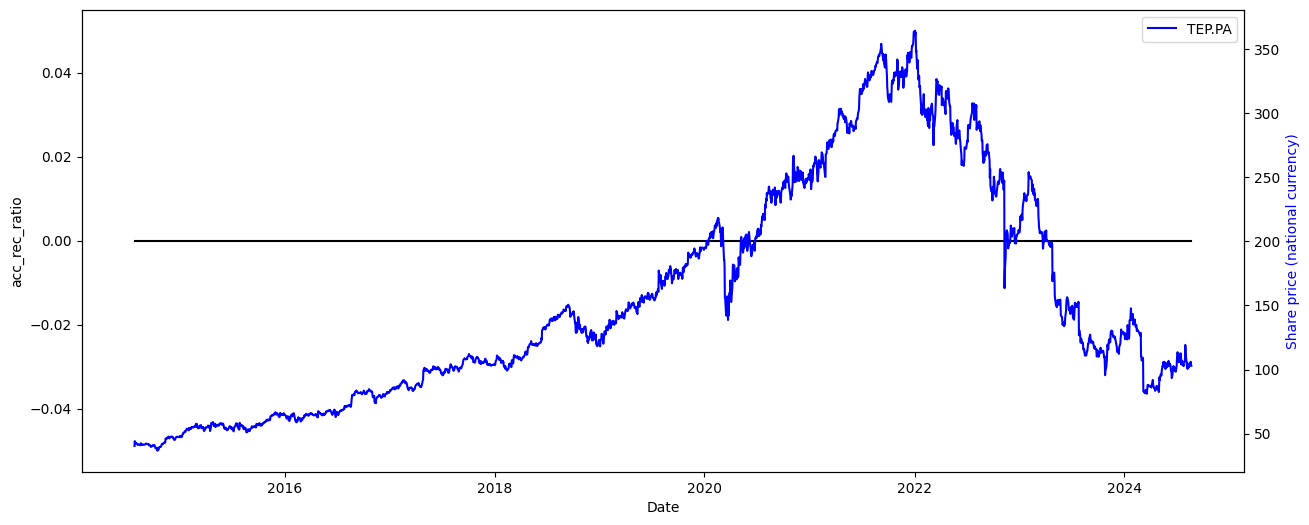

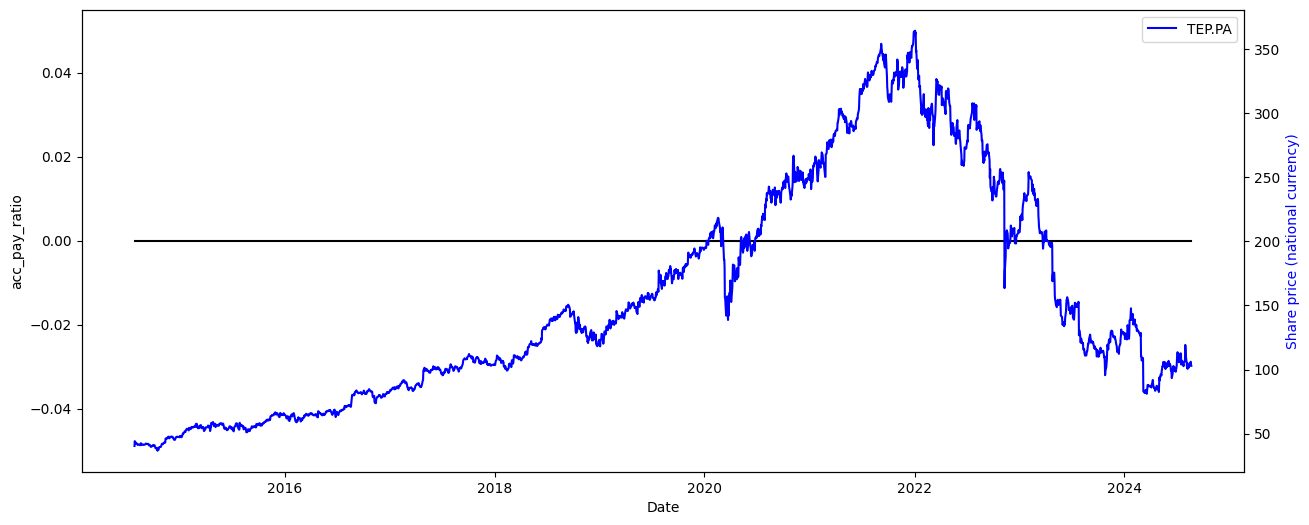

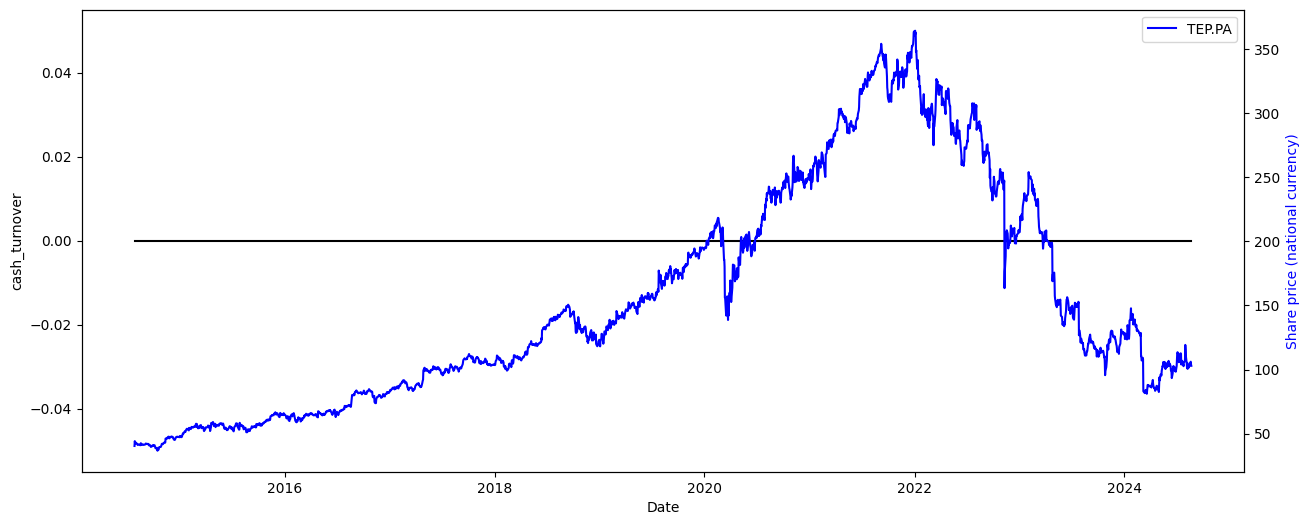

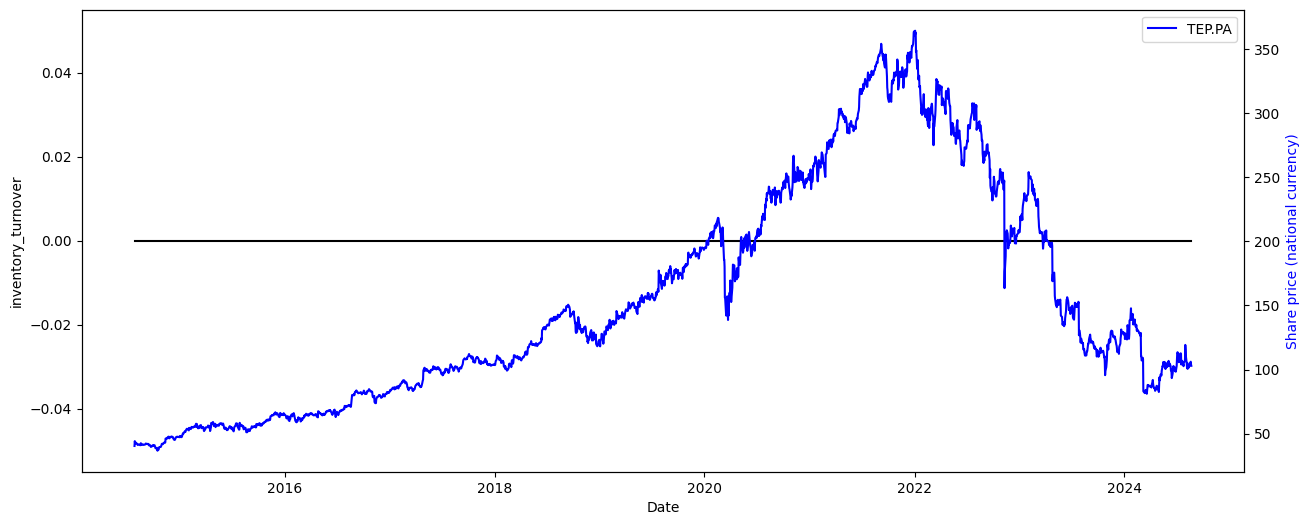

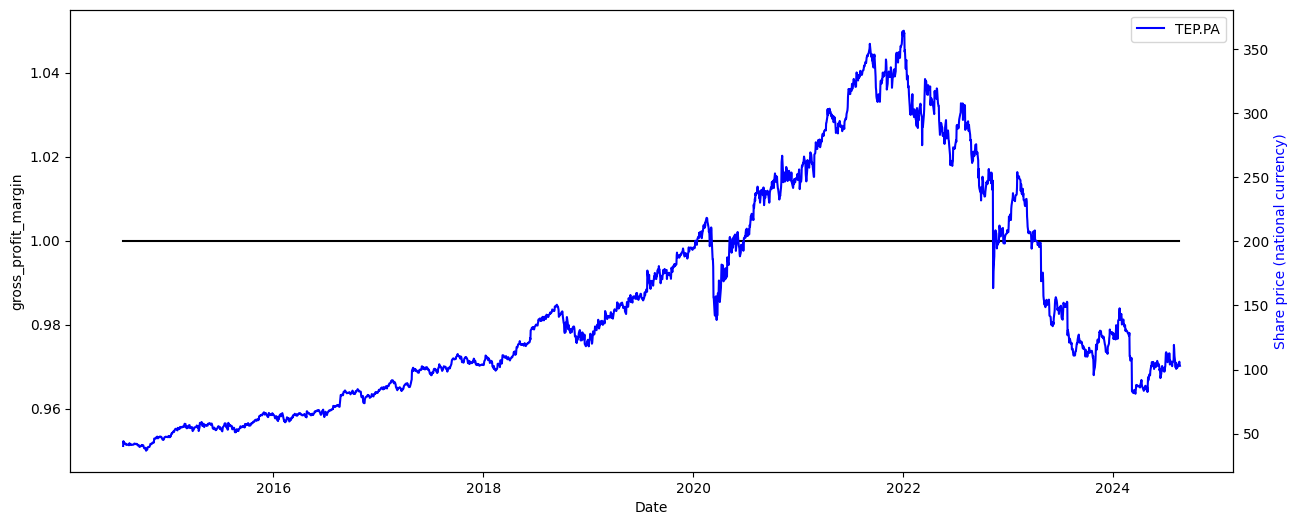

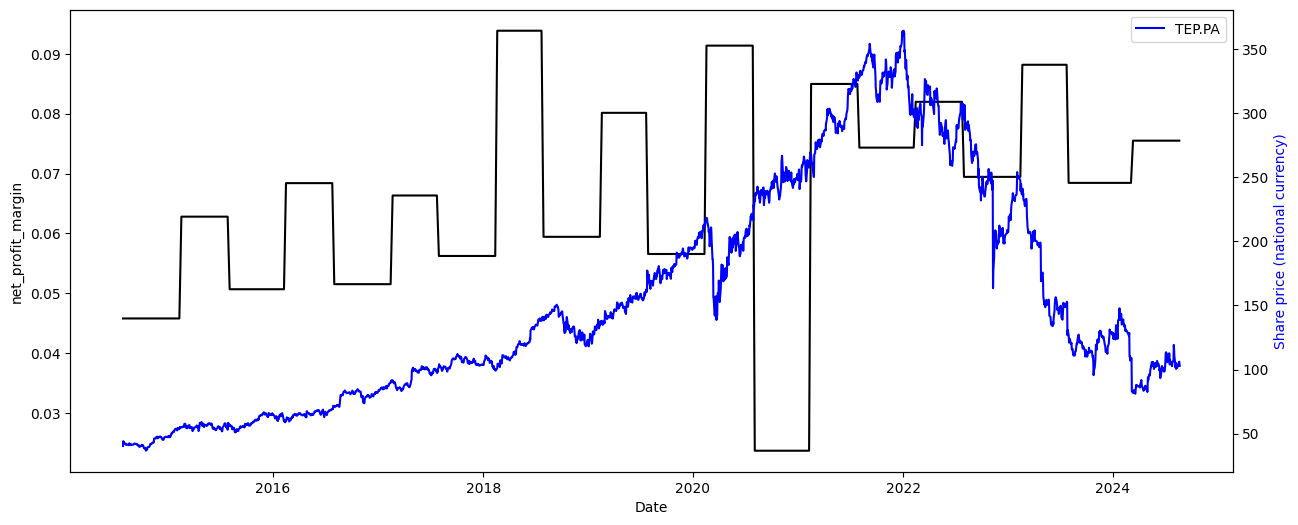

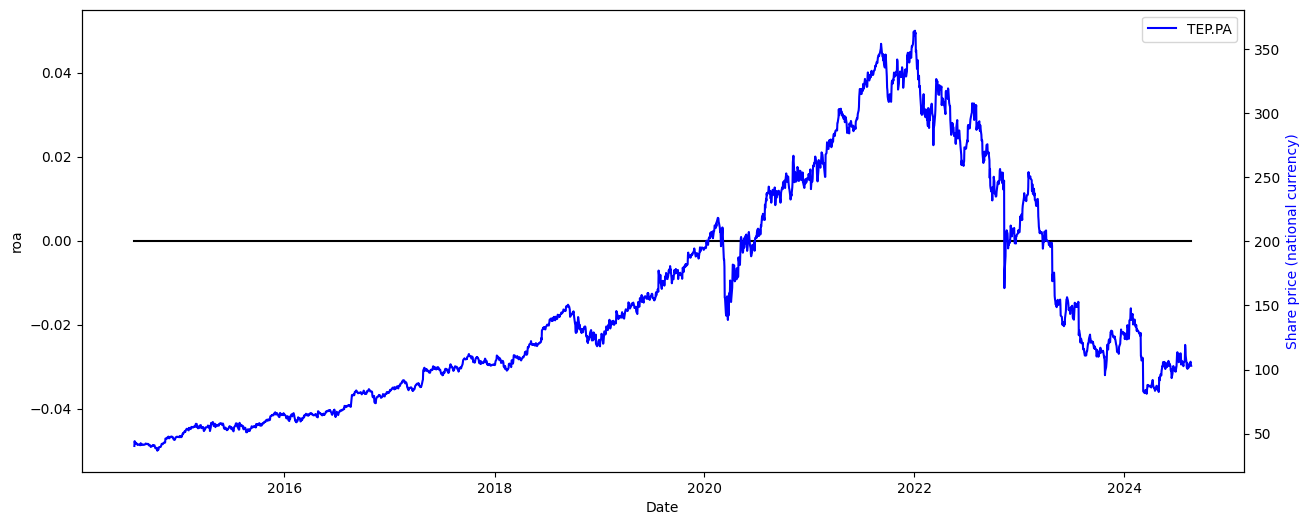

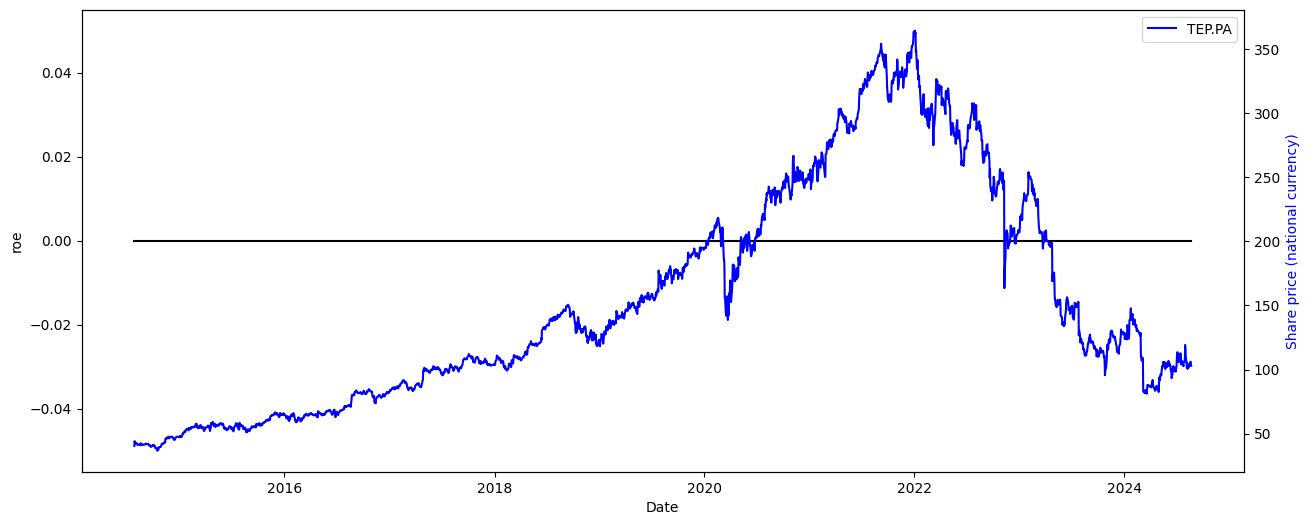

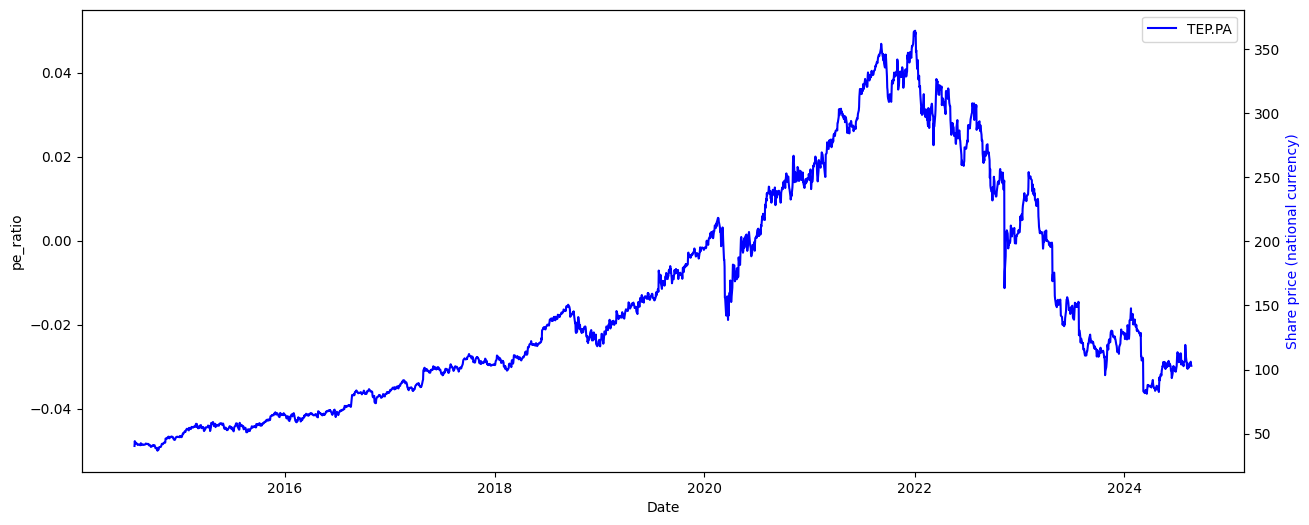

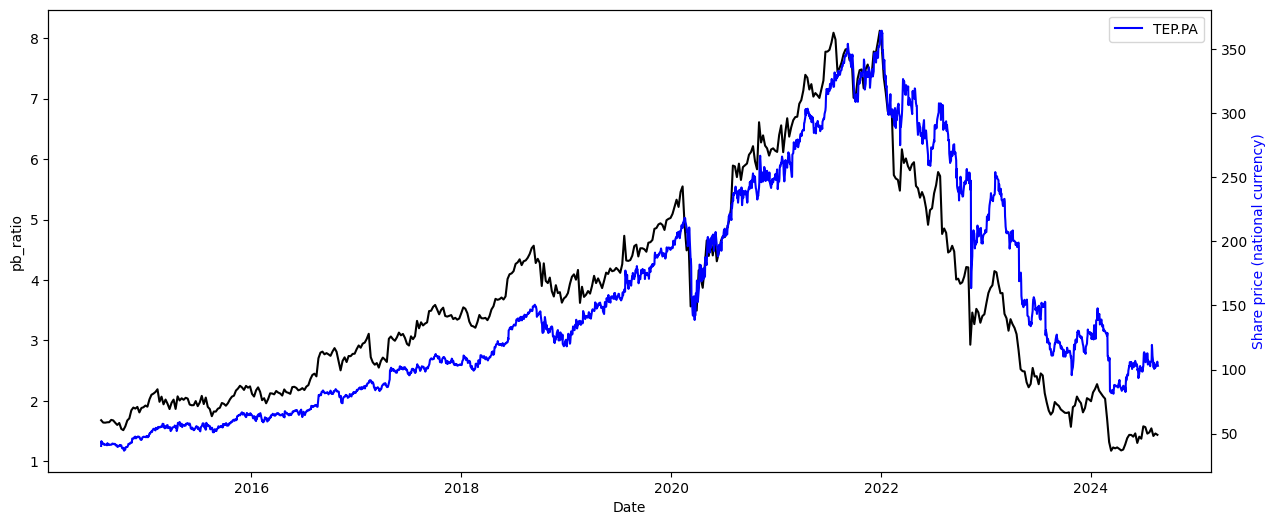

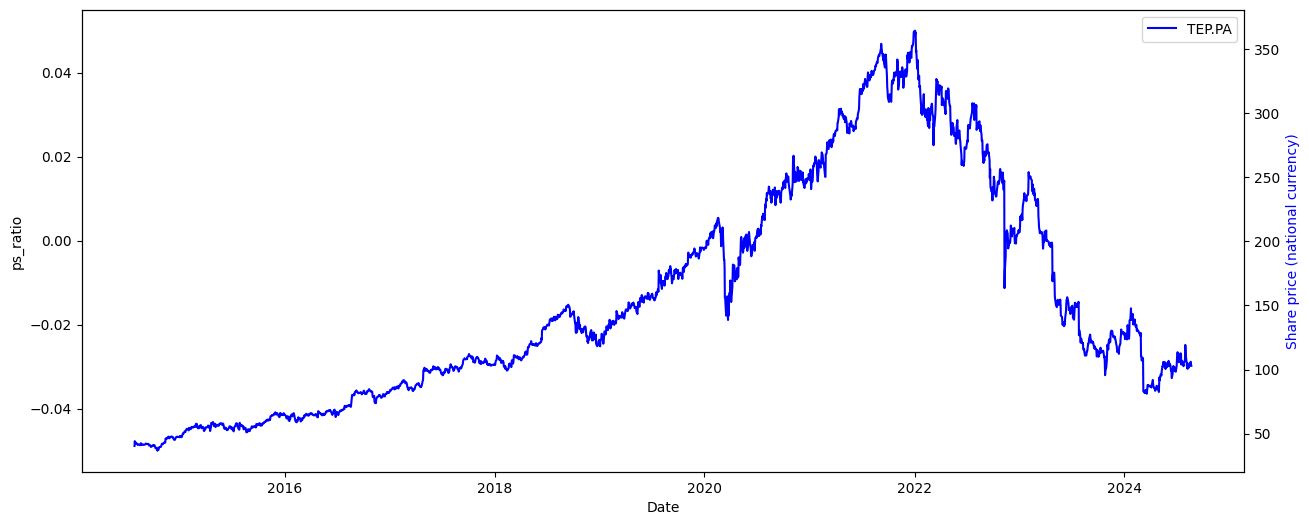

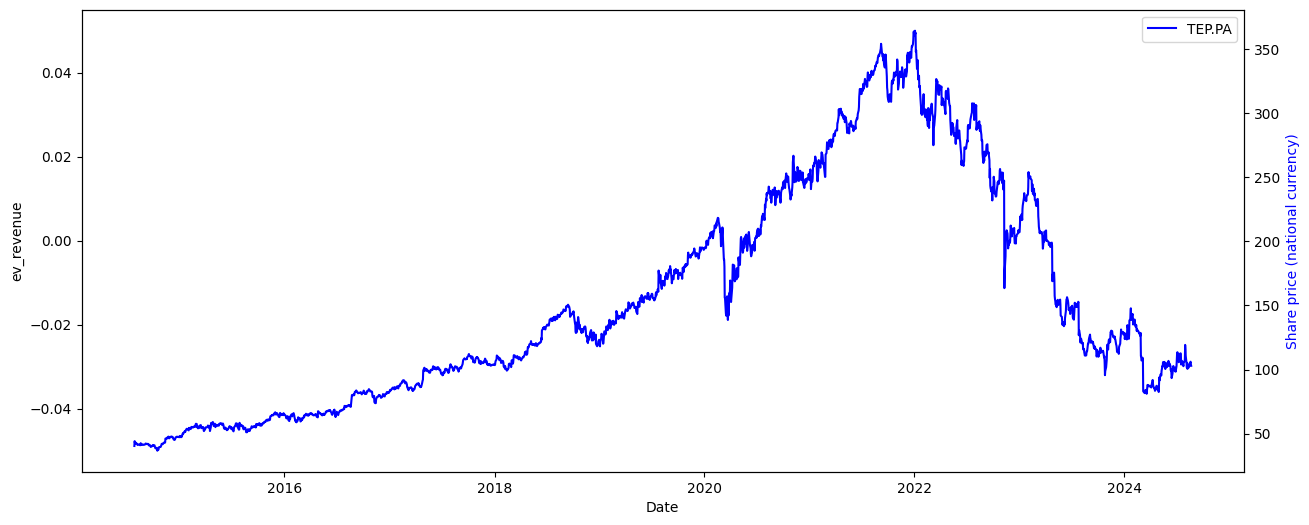

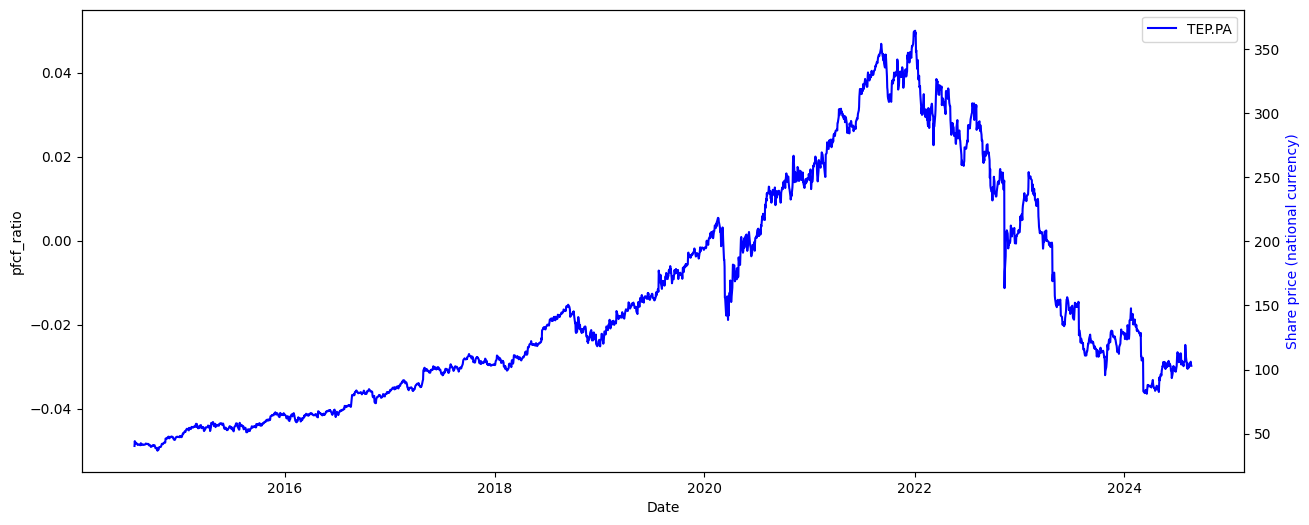

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

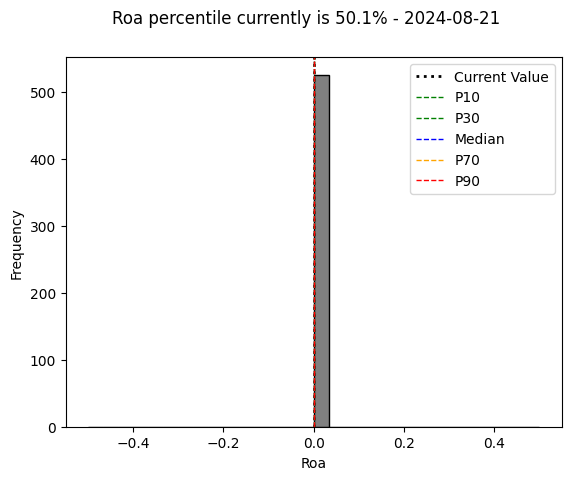

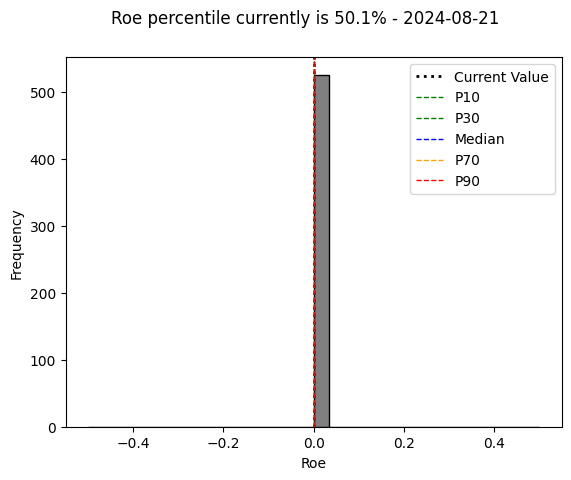

pe_ratio diagram is missing due to error.


/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


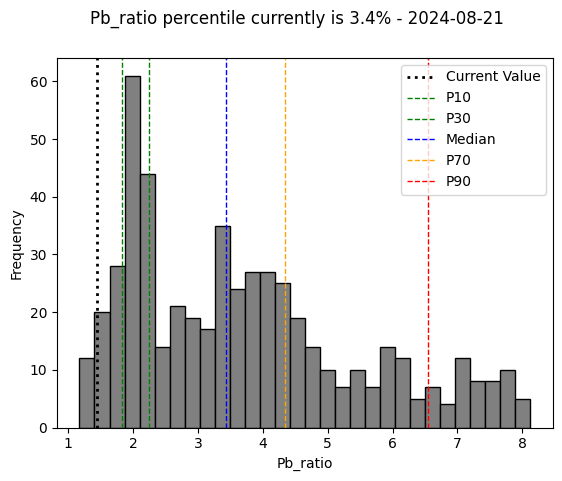

ps_ratio diagram is missing due to error.
ev_revenue diagram is missing due to error.


/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


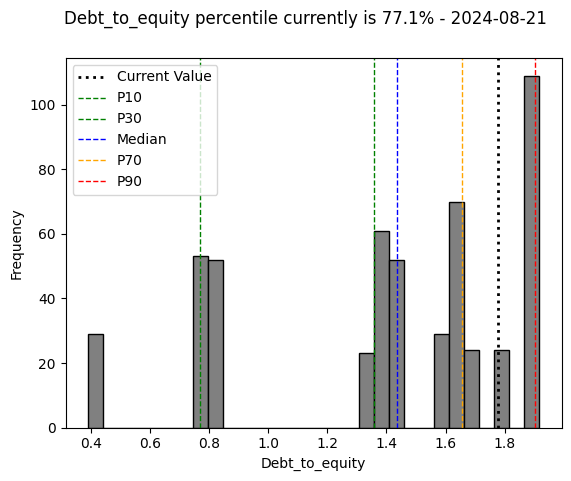

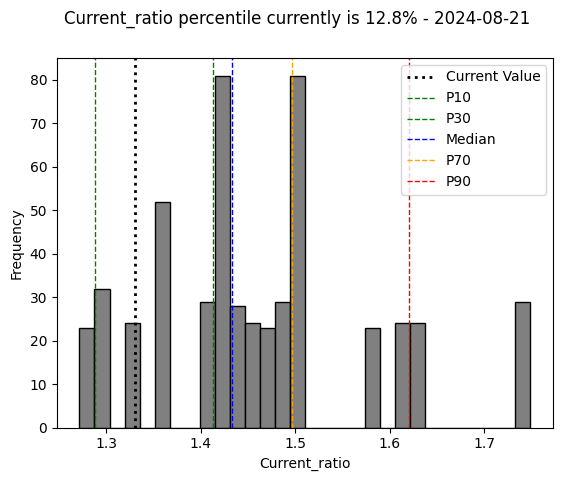

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pe_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pb_ratio,NaN,NaN,NaN,1.000000,NaN,NaN,0.680553,0.08888
ps_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ev_revenue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
debt_to_equity,NaN,NaN,NaN,0.680553,NaN,NaN,1.000000,-0.40546
current_ratio,NaN,NaN,NaN,0.088880,NaN,NaN,-0.405460,1.00000


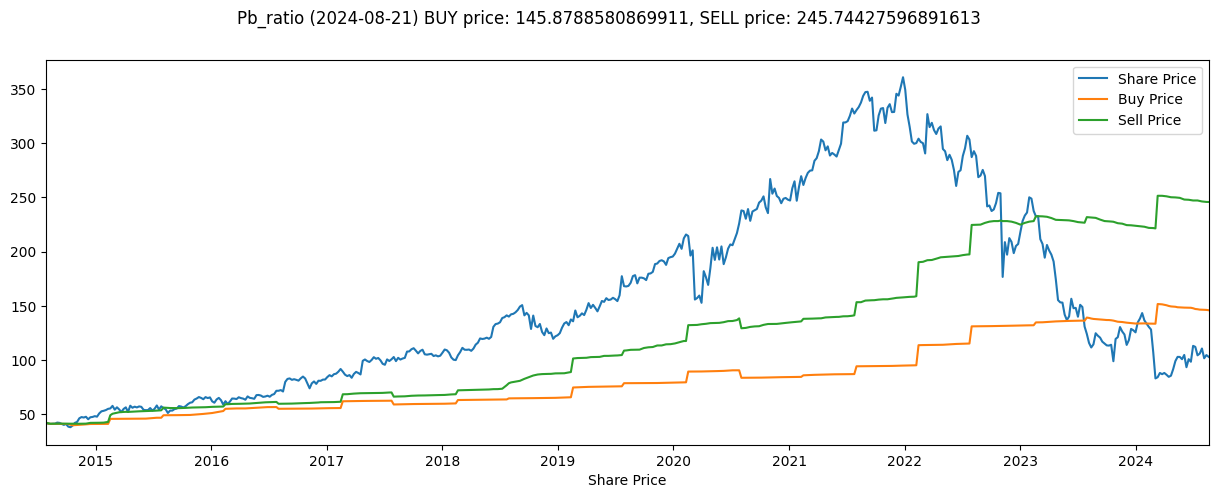

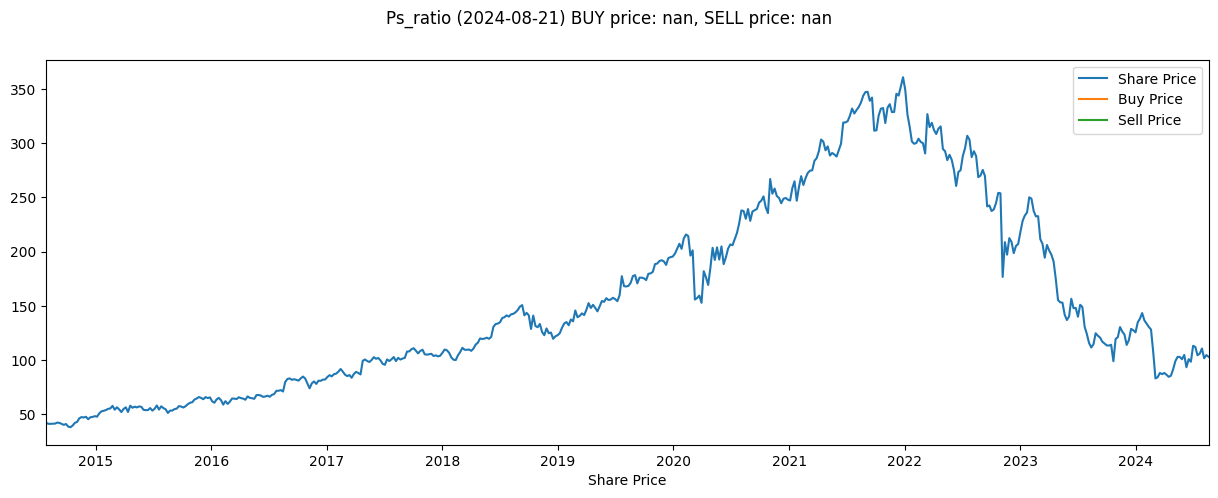

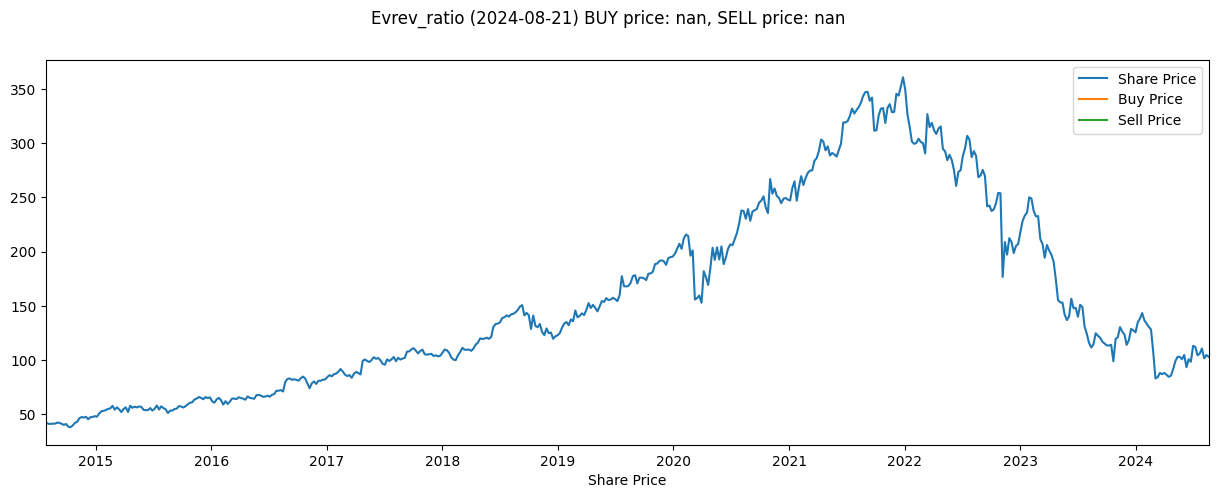

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)